# Install pix2pix

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_pix2pix_model.sh [edges2shoes, sat2map, map2sat, facades_label2photo, and day2night]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [ ]:
!bash ./scripts/download_pix2pix_model.sh day2night

# Training

In [ ]:
!python train.py --dataroot ./datasets/spectro --name spectro_pix2pix --model pix2pix --input_nc 1 --output_nc 1 --direction BtoA --continue_train

# Data processing

In [8]:
import os
import numpy as np
import torch
import torchaudio
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.io.wavfile as wavfile
import scipy
import cv2

In [265]:
# def audio_to_spectrogram(filename, n_fft=2048):
#     waveform, sample_rate = torchaudio.load(filename, normalize=True)
    
#     melspec_transform = torchaudio.transforms.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=n_fft
#     )
    
#     waveform = torch.mean(waveform, 0)
    
#     spectro = melspec_transform(waveform)
#     # spectro = librosa.power_to_db(spectro)
#     # plt.imshow(spectro)
    
#     return spectro, sample_rate
    
# def spectrogram_to_audio(spectro, n_fft=2048, sample_rate=44100):
#     inv_melspec_transform = torchaudio.transforms.InverseMelScale(
#         sample_rate=sample_rate, 
#         n_stft=int(n_fft/2 + 1)
#     )
#     spectro = inv_melspec_transform(spectro)
    
#     grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=n_fft)
#     audio = grifflim_transform(spectro)

#     torchaudio.save('data/attenborough/our_planet_1_4_NEW.wav', audio, sample_rate)

def waveform_to_spectrogram(filename):
    waveform, sample_rate = librosa.load(filename)
    
    D = np.abs(librosa.stft(waveform))**2
    spectro = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        S=D
    )
    
    return spectro, sample_rate


def spectrogram_to_audio(spectro, filename, sample_rate=44100):
    waveform = librosa.feature.inverse.mel_to_audio(spectro)
    
    # Conver to tensor so we can save using torchaudio
    waveform = np.reshape(waveform, (1, -1))
    waveform = torch.from_numpy(waveform)
    
    torchaudio.save(filename, waveform, sample_rate)
    
    
def spectrogram_to_image(spectro, filename, max_db=50, min_db=-100, img_size=(128,128)):
    # Convert to decibel scale
    spectro_db = librosa.power_to_db(spectro)
    spectro_db = cv2.resize(spectro_db, dsize=img_size)
    
    # Rescale pixel values to be between 0 and 255
    spectro_db -= min_db
    spectro_db *= 255.0 / (max_db - min_db)

    # plt.imshow(spectro_db)
    cv2.imwrite(filename, spectro_db)
    

def spectrogram_to_image_paired(spectro_A, spectro_B, filename, max_db=50, min_db=-100, img_size=(128,128)):
    # Convert to decibel scale
    spectro_db_A = librosa.power_to_db(spectro_A)
    spectro_db_A = cv2.resize(spectro_db_A, dsize=img_size)
    
    spectro_db_B = librosa.power_to_db(spectro_B)
    spectro_db_B = cv2.resize(spectro_db_B, dsize=img_size)
    
    spectro_db = cv2.hconcat([spectro_db_A, spectro_db_B])
    
    # Rescale pixel values to be between 0 and 255
    spectro_db -= min_db
    spectro_db *= 255.0 / (max_db - min_db)

    # plt.imshow(spectro_db)
    cv2.imwrite(filename, spectro_db)

Filter Attenborough audio to try remove most of the background noise

In [222]:
def filter_audio(dir_name):
    TOTAL_FILES = len(os.listdir(dir_name))

    for i, filename in enumerate(os.scandir(dir_name)):
        try:
            fn = os.path.splitext(filename)[0]
            fn = filename.path.split("\\")[-1].split(".")[0]

            # Based off of tutorial: https://librosa.org/librosa_gallery/auto_examples/plot_vocal_separation.html
            waveform, sample_rate = librosa.load(filename.path)
            waveform = np.pad(waveform, (1000, 1000), 'reflect')

            # And compute the spectrogram magnitude and phase
            spectro, phase = librosa.magphase(librosa.stft(waveform))

            spectro_filter = librosa.decompose.nn_filter(spectro,
                                                   aggregate=np.median,
                                                   metric='cosine',
                                                   width=int(librosa.time_to_frames(1.0, sr=sr)))

            # The output of the filter shouldn't be greater than the input
            # if we assume signals are additive.  Taking the pointwise minimium
            # with the input spectrum forces this.
            spectro_filter = np.minimum(spectro, spectro_filter)      

            # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
            # Note: the margins need not be equal for foreground and background separation
            margin = 7
            power = 2

            mask_v = librosa.util.softmask(spectro - spectro_filter,
                                           margin * spectro_filter,
                                           power=power)

            # Once we have the masks, simply multiply them with the input spectrum
            # to separate the components
            filtered_spectro = mask_v * spectro

            filtered_waveform = librosa.istft(filtered_spectro * phase)
            filtered_waveform = np.reshape(filtered_waveform, (1, -1))
            filtered_waveform = torch.from_numpy(filtered_waveform)

            torchaudio.save(dir_name + "_filtered/" + fn + ".wav", filtered_waveform, sr)
        except Exception as e:
            print("Failed ", fn)
            print(e)
            
        
        if (i + 1) % 100 == 0:
            print("Converted: ", i + 1, "/", TOTAL_FILES, " files")
            

dir_input = 'data/attenborough'
dir_output = 'data/gtts'
            
filter_audio(dir_input)

Get minimum and maximum dB of waveforms so that we can uniformly scale all of the spectrograms between 0-255 later.

In [226]:
# Get stats of spectrograms

dir_input = 'data/attenborough_filtered'
dir_output = 'data/gtts'


def get_audio_stats(dir_name):
    max_db = 0
    min_db = 0
    TOTAL_FILES = len(os.listdir(dir_name))

    for i, filename in enumerate(os.scandir(dir_name)):
        fn = os.path.splitext(filename)[0]
        fn = filename.path.split("\\")[-1].split(".")[0]

        spectro, sample_rate = waveform_to_spectrogram(filename.path)
        spectro_db = librosa.power_to_db(spectro)

        if np.max(spectro_db) > max_db:
            max_db = np.max(spectro_db)
        elif np.min(spectro_db) < min_db:
            min_db = np.min(spectro_db)

        if (i + 1) % 100 == 0:
            print("Converted: ", i + 1, "/", TOTAL_FILES, " files")
            print("\tMax dB: ", max_db)
            print("\tMin dB: ", min_db)
            
    return max_db, min_db

max_db_in, min_db_in = get_audio_stats(dir_input)
max_db_out, min_db_out = get_audio_stats(dir_output)    

max_db = max(max_db_in, max_db_out)
min_db = min(min_db_in, min_db_out)

print("Max dB: ", max_db)
print("Min dB: ", min_db)
    
# spectro, sample_rate = waveform_to_spectrogram(filename.path)
# spectrogram_to_image(spectro, "data/spectro/" + prefix + fn + ".png", img_size=(128,128))

Converted:  100 / 1004  files
	Max dB:  21.825138
	Min dB:  -70.37315
Converted:  200 / 1004  files
	Max dB:  21.825138
	Min dB:  -76.1583
Converted:  300 / 1004  files
	Max dB:  22.749779
	Min dB:  -76.1583
Converted:  400 / 1004  files
	Max dB:  27.046486
	Min dB:  -76.1583
Converted:  500 / 1004  files
	Max dB:  27.046486
	Min dB:  -76.1583
Converted:  600 / 1004  files
	Max dB:  27.046486
	Min dB:  -76.1583
Converted:  700 / 1004  files
	Max dB:  27.046486
	Min dB:  -93.06307
Converted:  800 / 1004  files
	Max dB:  27.046486
	Min dB:  -93.06307
Converted:  900 / 1004  files
	Max dB:  27.046486
	Min dB:  -93.06307
Converted:  1000 / 1004  files
	Max dB:  27.046486
	Min dB:  -93.06307


C:\Users\Kerry He\AppData\Roaming\Python\Python39\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Converted:  100 / 1005  files
	Max dB:  29.538147
	Min dB:  -54.700066
Converted:  200 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  300 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  400 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  500 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  600 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  700 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  800 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  900 / 1005  files
	Max dB:  30.256348
	Min dB:  -56.538773
Converted:  1000 / 1005  files
	Max dB:  30.362976
	Min dB:  -56.538773
Max dB:  30.362976
Min dB:  -93.06307


Convert audio waveforms to spectrograms. pix2pix seems to require paired images.

In [266]:
dir_input = 'data/attenborough_filtered'
dir_output = 'data/gtts'


# Convert audio files to spectrogram
def wav_to_spectro(dir_name, train_val_test_pc, AB, max_db, min_db):
    TOTAL_FILES = len(os.listdir(dir_name))
    
    val_cnt = round(TOTAL_FILES * train_val_test_pc[1])
    test_cnt = round(TOTAL_FILES * train_val_test_pc[2])
    
    for i, filename in enumerate(sorted(os.scandir(dir_name), key=lambda e: e.name)):
        if i < val_cnt:
            prefix = "val" + AB + "/"
        elif i < val_cnt + test_cnt:
            prefix = "test" + AB + "/"
        else:
            prefix = "train" + AB + "/"
        
        fn = os.path.splitext(filename)[0]
        fn = filename.path.split("\\")[-1].split(".")[0]

        spectro, sample_rate = waveform_to_spectrogram(filename.path)
        spectrogram_to_image(spectro, "data/spectro/" + prefix + fn + ".png", max_db, min_db, img_size=(128,128))

        if (i + 1) % 100 == 0:
            print("Converted: ", i + 1, "/", TOTAL_FILES, " files")

            
def wav_to_spectro_paired(dir_A, dir_B, train_val_test_pc, max_db, min_db):
    TOTAL_FILES = len(os.listdir(dir_A))
    
    val_cnt = round(TOTAL_FILES * train_val_test_pc[1])
    test_cnt = round(TOTAL_FILES * train_val_test_pc[2])
    
    for i, filename in enumerate(sorted(os.scandir(dir_A), key=lambda e: e.name)):
        if i < val_cnt:
            prefix = "val/"
        elif i < val_cnt + test_cnt:
            prefix = "test/"
        else:
            prefix = "train/"
        
        fn = os.path.splitext(filename)[0]
        fn = filename.path.split("\\")[-1].split(".")[0]

        spectro_A, sample_rate = waveform_to_spectrogram(dir_A + "/" + fn + ".wav")
        spectro_B, sample_rate = waveform_to_spectrogram(dir_B + "/" + fn + ".mp3")
        
        spectrogram_to_image_paired(spectro_A, spectro_B, "data/spectro/" + prefix + fn + ".png", max_db, min_db, img_size=(128,128))

        if (i + 1) % 100 == 0:
            print("Converted: ", i + 1, "/", TOTAL_FILES, " files")


from pathlib import Path
# for train_val_test in ["train", "val", "test"]:
#     for AB in ["A", "B"]:
#         Path("data/spectro/" + train_val_test + AB).mkdir(parents=True, exist_ok=True)
for train_val_test in ["train", "val", "test"]:
    Path("data/spectro/" + train_val_test).mkdir(parents=True, exist_ok=True)
            

train_val_test_pc = [0.85, 0.10, 0.05]
    
# wav_to_spectro(dir_input, train_val_test_pc, "A", max_db, min_db)
# wav_to_spectro(dir_output, train_val_test_pc, "B", max_db, min_db)

wav_to_spectro_paired(dir_input, dir_output, train_val_test_pc, max_db, min_db)

Converted:  100 / 1004  files
Converted:  200 / 1004  files
Converted:  300 / 1004  files
Converted:  400 / 1004  files
Converted:  500 / 1004  files
Converted:  600 / 1004  files
Converted:  700 / 1004  files
Converted:  800 / 1004  files
Converted:  900 / 1004  files
Converted:  1000 / 1004  files


Sample code to try to revert spectrogram back to audio

12.454098480823006
17.595833672410897


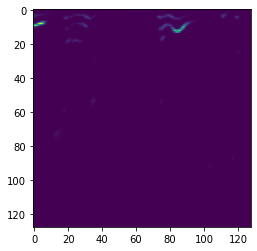

In [259]:
img = cv2.imread('pytorch-CycleGAN-and-pix2pix\checkpoints\spectro_pix2pix\web\images/epoch055_real_B.png', 0)
img = img.astype(float)

img = cv2.resize(img, (128, 128))
# img = cv2.flip(img, 1)

img /= 255.0 / (max_db - min_db)
img += min_db

img = librosa.db_to_power(img)
spectrogram_to_audio(img, 'pytorch-CycleGAN-and-pix2pix\checkpoints\spectro_pix2pix\web\images/epoch061_fake_B.wav', sample_rate=int(44100/2))

plt.imshow(img)

Some code to convert .mp3 files to .wav

In [4]:
dir_input = 'data\\attenborough'
dir_output = 'data\\gtts'


# Convert all files into .wav format
def convert_to_wav(dir_name):
    TOTAL_FILES = len(os.listdir(dir_name))
    for i, filename in enumerate(os.scandir(dir_name)):
        fn = os.path.splitext(filename)[0]
        fn = filename.path.split("\\")[-1].split(".")[0]

        sound = AudioSegment.from_mp3(filename)
        sound.export(dir_name + "_wav/" + fn + ".wav", format="wav")

        if (i + 1) % 100 == 0:
            print("Converted: ", i + 1, "/", TOTAL_FILES, " files")


convert_to_wav(dir_input)
convert_to_wav(dir_output)

Converted:  100 / 1005  files
Converted:  200 / 1005  files
Converted:  300 / 1005  files
Converted:  400 / 1005  files
Converted:  500 / 1005  files
Converted:  600 / 1005  files
Converted:  700 / 1005  files
Converted:  800 / 1005  files
Converted:  900 / 1005  files
Converted:  1000 / 1005  files
Converted:  100 / 1005  files
Converted:  200 / 1005  files
Converted:  300 / 1005  files
Converted:  400 / 1005  files
Converted:  500 / 1005  files
Converted:  600 / 1005  files
Converted:  700 / 1005  files
Converted:  800 / 1005  files
Converted:  900 / 1005  files
Converted:  1000 / 1005  files


Tutorial code for filtering out background noise

C:\Users\Kerry He\AppData\Roaming\Python\Python39\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(1025, 241)


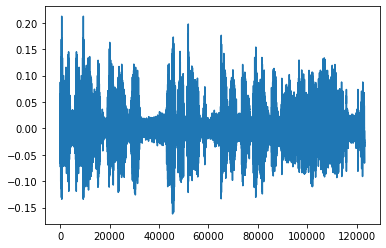

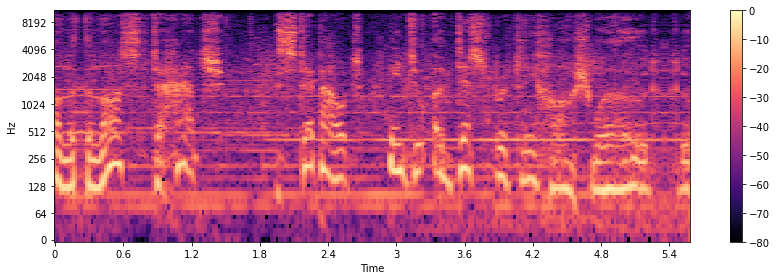

In [195]:
y, sr = librosa.load('data/attenborough/our_planet_1_129.mp3')
y = np.pad(y, (5000, 5000), 'reflect')
plt.plot(y)
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))
print(S_full.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [207]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(1.5, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [208]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

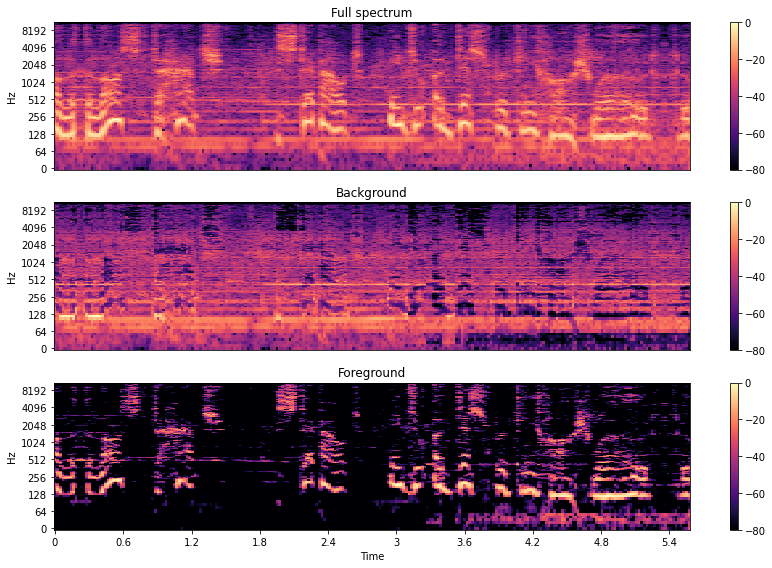

In [209]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()


In [210]:
def spectrogram_to_audio(spectro, filename, sample_rate=44100):
    waveform = librosa.feature.inverse.mel_to_audio(spectro)
    
    # Conver to tensor so we can save using torchaudio
    waveform = np.reshape(waveform, (1, -1))
    waveform = torch.from_numpy(waveform)
    
    torchaudio.save(filename, waveform, sample_rate)

y_foreground = librosa.istft(S_foreground * phase)
waveform = np.reshape(y_foreground, (1, -1))
waveform = torch.from_numpy(waveform)

torchaudio.save('data/attenborough/our_planet_1_145.wav', waveform, sr)
# spectrogram_to_audio(y_foreground, 'data/attenborough/our_planet_1_145.wav', sample_rate=int(44100/2))
print(waveform.shape)

torch.Size([1, 122880])
